In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
import pandas as pd
import scipy
import scipy.io as sio
#import sys
#ssys.path.append('../mnist-timit/')
from momentumnet import MomentumLSTMCell
from momentumnet import AdamLSTMCell
from sklearn.metrics import mean_squared_error as mse



class RNN(nn.Module):
    def __init__(self,input_dim,num_units,output_dim,cell_type='plain',dropout=False):
        super(RNN,self).__init__()
        self.num_units=num_units
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.dropout1=nn.Dropout(p=0.1)
        self.dropout2=nn.Dropout(p=0.1)
        self.lstm1=nn.LSTMCell(input_dim,num_units[0])
        self.dropout=dropout
        self.cell_type=cell_type
        if cell_type=='plain':
            self.lstm2=nn.LSTMCell(num_units[0],num_units[1])
            self.lstm3=nn.LSTMCell(num_units[1],num_units[2])
        if cell_type=='momentum':
            self.lstm2=MomentumLSTMCell(self.num_units[0],self.num_units[1],mu=0.1,epsilon=1)
            self.lstm3=MomentumLSTMCell(num_units[1],num_units[2],mu=0.1,epsilon=1)
        if cell_type=='Adam':
            self.lstm2=AdamLSTMCell(self.num_units[0],self.num_units[1],mu=0.9,epsilon=0.1,mus=0.9)
            #self.lstm2=MomentumLSTMCell(self.num_units[0],self.num_units[1],mu=0.8,epsilon=0.2)
            self.lstm3=AdamLSTMCell(num_units[1],num_units[2],mu=0.9,epsilon=0.1,mus=0.9)
        self.linear=nn.Linear(num_units[-1],self.output_dim)
        
    def forward(self,input):
        #print(input.size[1])
        h_t = torch.zeros(input.size(0), self.num_units[0], dtype=torch.float)
        c_t = torch.zeros(input.size(0), self.num_units[0], dtype=torch.float)
        v1 = torch.zeros(input.size(0),  4*self.num_units[0],dtype=torch.float)
        #print(v1.size())
        h_t2 = torch.zeros(input.size(0), self.num_units[1], dtype=torch.float)
        c_t2 = torch.zeros(input.size(0), self.num_units[1], dtype=torch.float)
        v2 = torch.zeros(input.size(0), 4* self.num_units[1],dtype=torch.float)
        s2 = torch.zeros((input.size(0), 4 * self.num_units[1]), dtype=torch.float)
        h_t3 = torch.zeros(input.size(0), self.num_units[2], dtype=torch.float)
        c_t3 = torch.zeros(input.size(0), self.num_units[2], dtype=torch.float)
        v3 = torch.zeros(input.size(0), 4 * self.num_units[2], dtype=torch.float)
        s3 = torch.zeros((input.size(0), 4 * self.num_units[2]), dtype=torch.float)
        h_t, c_t = self.lstm1(input, (h_t, c_t))
        if self.dropout:
            h_t=self.dropout1(h_t)
        if self.cell_type=='plain':
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
        elif self.cell_type=='momentum':
            h_t2, _, _ = self.lstm2(h_t, (h_t2, c_t2), v2)
        elif self.cell_type=='Adam':
            ht_2,_,_,_=self.lstm2(h_t,(h_t2, c_t2), v2, s2) 
            #h_t2, _, _ = self.lstm2(h_t, (h_t2, c_t2), v2)
        if self.dropout:
            h_t2=self.dropout2(h_t2)
        if self.cell_type=='plain':
            h_t3, c_t3=self.lstm3(h_t2, (h_t3, c_t3))
        elif self.cell_type=='momentum':
            h_t3, _, _ = self.lstm3(h_t2, (h_t3, c_t3),v3)
        elif self.cell_type=='Adam':
            ht_3,_,_,_=self.lstm3(h_t2, (h_t3, c_t3), v3, s3) 
        if self.dropout:
            output=self.linear(h_t3)
        #return output
        return h_t3
    
    
class NodeRNN(nn.Module):
    def __init__(self,input_dim,hidden_size,num_layers,output_dim):
        super(NodeRNN,self).__init__()
        self.lstm=nn.LSTM(input_dim,hidden_size,num_layers)
        self.linear=nn.Linear(hidden_size,output_dim)
        #self.linear=nn.Linear(input_dim,output_dim)
        self.dropout=nn.Dropout(p=0.1)
    def forward(self,input):
        h_t,_=self.lstm(input)
        h_t=h_t[:,-1,:]
        output=self.linear(h_t)
        #output=nn.functional.relu(output)
        return output


In [3]:
import GenerateData
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


samples=800
predictions=200


DataReader=GenerateData.DataReaderPowergrid(samples,predictions)
trX_raw, trY_raw = DataReader.GenerateNodeFeatures()
num_files=trX_raw[0].shape[0]
#dynamic=True to make graph weights trainable
dynamic=False
graph=DataReader.GenerateGraph(dynamic=dynamic)

DataReader.load_graph(graph)
trX_raw, trY_raw=DataReader.GenerateNodeFeatures()
node_to_type=DataReader.GenerateNodeClassification1(num_group=2)
trX,trY=DataReader.add_edge_features(trX_raw,trY_raw)
cls=np.array([node_to_type[t] for t in node_to_type])
cls_list=np.unique(cls)
for cl in cls_list:
    print("Num Nodes in Class", cl," : ", np.sum(cls==cl))
node_list={}
for cl in cls_list:
    node_list[cl]=[v for v in node_to_type if node_to_type[v]==cl]
X_train={}
Y_train={}
for cl in cls_list:
    Y_train[cl]=[]
    for k in range(num_files):
        num_nodes=np.sum(cls==cl)
        temp=np.empty((num_nodes,predictions),dtype=np.float32)
        for i in range(num_nodes):
            temp[i,:]=trY[node_list[cl][i]][k,:]
        Y_train[cl].append(temp)
for cl in cls_list:
    X_train[cl]={}
    for edge in DataReader.type_to_edge_connections[cl]:
        data_list=[]
        for k in range(num_files):
            num_nodes=np.sum(cls==cl)
            temp=np.empty((num_nodes,samples),dtype=np.float32)
            for i in range(num_nodes):
                temp[i,:]=trX[node_list[cl][i]][edge][k,:]
            data_list.append(temp)
        X_train[cl][edge]=data_list

/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

Num Nodes in Class 0  :  32
Num Nodes in Class 1  :  36


/home/student1/Desktop/MomentumRNN/test/GenerateData.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  X[:,:]=generate_data(file_num1,suffix1,[])[0][:,:1000]


In [8]:
dynamic=False
graph=DataReader.GenerateGraph(dynamic=dynamic)



num_units=[150,200,150]
 
    
cl=1
cell_type='momentum'
EdgeRNNs={}
for edge in DataReader.type_to_edge_connections[cl]:
    EdgeRNNs[edge]=RNN(input_dim=samples,num_units=num_units,output_dim=predictions,cell_type=cell_type)

NLSTM=NodeRNN(num_units[-1],30,3,predictions)
nets=[net for net in EdgeRNNs.values()]+[NLSTM]
params=[list(net.parameters()) for net in EdgeRNNs.values()][0]
params+=list(NLSTM.parameters())
optimizer=torch.optim.Adam(params,lr=0.01)

scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[500,1000],gamma=0.1)
criterion=torch.nn.MSELoss()
for epoch in range(700):
    total_loss=0.0
    
    for k in range(4):
        Y=torch.from_numpy(Y_train[cl][k+1])
        Y=Variable(Y)
        edge_outputs=[]
        for edge in DataReader.type_to_edge_connections[cl]:
            X=torch.from_numpy(X_train[cl][edge][k+1])
            X=Variable(X)
            output=EdgeRNNs[edge](X)
            edge_outputs+=[output.unsqueeze(1)]
        X=torch.cat(edge_outputs,1)
        y_pred=NLSTM(X)
        loss=criterion(y_pred,Y)
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    if epoch%50==0:
        print('loss: ',total_loss)
for net in EdgeRNNs.values():
    net.eval()
NLSTM.eval()
k=0
Y_test=Y_train[cl][k]
Y=Variable(torch.from_numpy(Y_train[cl][k]))
edge_outputs=[]
for edge in DataReader.type_to_edge_connections[cl]:
    X=torch.from_numpy(X_train[cl][edge][k])
    X=Variable(X)
    output=EdgeRNNs[edge](X)
    edge_outputs+=[output.unsqueeze(1)]
X=torch.cat(edge_outputs,1)
y_pred=NLSTM(X)
loss=criterion(y_pred,Y)
y_pred=y_pred.data.numpy()
print('test loss: ', loss)
   
    
        

/home/student1/.local/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/student1/.local/lib/python3.6/site-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss:  tensor(1.9872, grad_fn=<AddBackward0>)
loss:  tensor(0.0695, grad_fn=<AddBackward0>)
loss:  tensor(0.0644, grad_fn=<AddBackward0>)
loss:  tensor(0.0634, grad_fn=<AddBackward0>)
loss:  tensor(1.4737, grad_fn=<AddBackward0>)
loss:  tensor(0.0651, grad_fn=<AddBackward0>)
loss:  tensor(0.0585, grad_fn=<AddBackward0>)
loss:  tensor(0.0576, grad_fn=<AddBackward0>)
loss:  tensor(0.0637, grad_fn=<AddBackward0>)
loss:  tensor(0.0104, grad_fn=<AddBackward0>)
loss:  tensor(0.0069, grad_fn=<AddBackward0>)
loss:  tensor(0.0065, grad_fn=<AddBackward0>)
loss:  tensor(0.0060, grad_fn=<AddBackward0>)
loss:  tensor(0.0060, grad_fn=<AddBackward0>)
test loss:  tensor(0.0050, grad_fn=<MseLossBackward>)


First 5 nodes of class 0: 


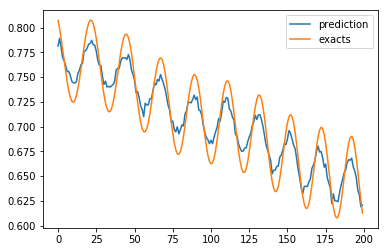

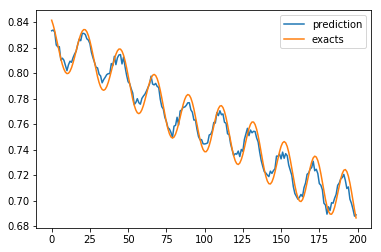

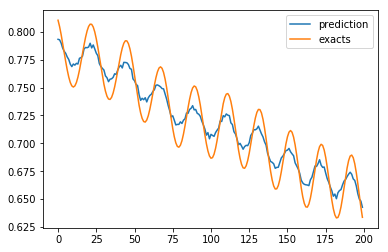

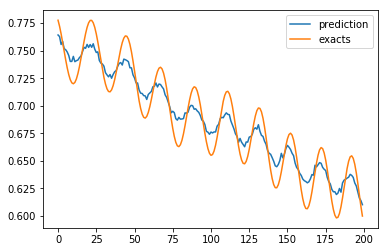

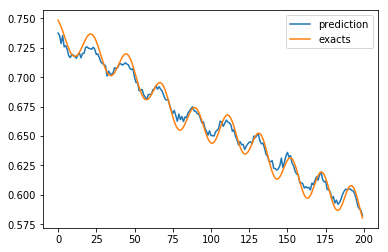

In [6]:
#nodes=range(np.sum(cls==cl))
print('First 5 nodes of class 0: ')
nodes=[0,1,2,3,4]
for i,k in enumerate(nodes):
    plt.plot(y_pred[k,:],label='prediction')
    plt.plot(Y_test[k,:],label='exacts')
    plt.legend()
    plt.show()

First 5 nodes of class 1: 


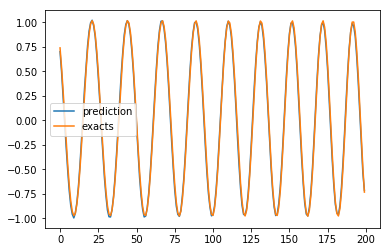

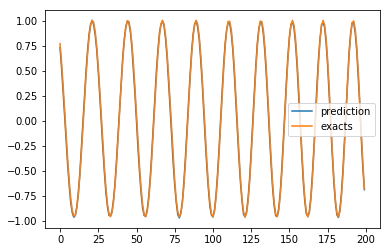

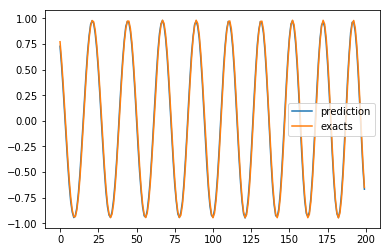

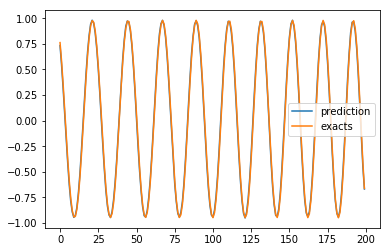

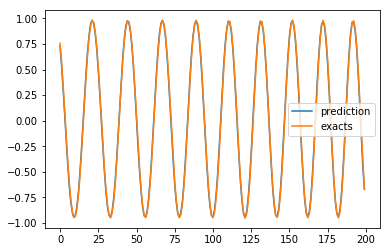

In [9]:
print('First 5 nodes of class 1: ')
nodes=[0,1,2,3,4]
for i,k in enumerate(nodes):
    plt.plot(y_pred[k,:],label='prediction')
    plt.plot(Y_test[k,:],label='exacts')
    plt.legend()
    plt.show()

In [103]:
filename=cell_type+'class'+str(cl)
if dynamic:
    filename+='dynamic'
filename+='.csv'
np.savetxt('result/'+filename,y_pred,delimiter=',')
np.savetxt('result/'+str(cl)+'exact'+'.csv',Y_test,delimiter=',')

The worst 5 nodes
error:  0.006617067


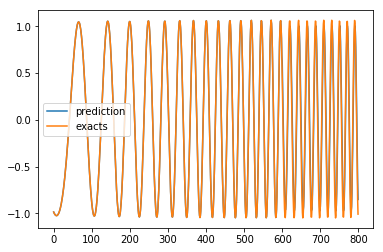

error:  0.004365508


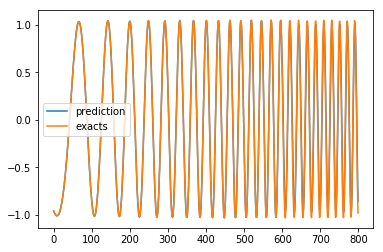

error:  0.0038314965


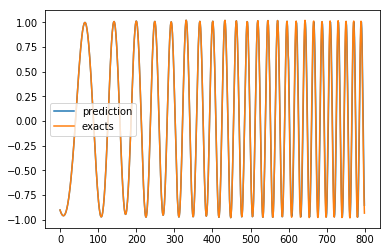

error:  0.0022018442


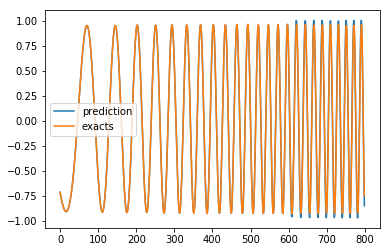

error:  0.0019118835


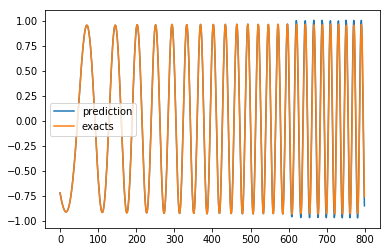

In [49]:
print('The worst 5 nodes')
for i in range(5):
    node=index[-(i+1)]
    y_hat=np.concatenate((X_test[node,:],pred[node,:]),axis=None)
    y=np.concatenate((X_test[node,:],Y_test[node,:]),axis=None)
    print('error: ', mse(y,y_hat))
    plt.plot(y_hat,label='prediction')
    plt.plot(y,label='exacts')
    plt.legend()
    plt.show()